In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

# Final model for 180 dataset

In [10]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")
X = X.drop(["max_consecutive_highwind_days", "Densità", "count_highwind", "type_rural", "type_urban"], axis=1)

In [11]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [12]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)

day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [13]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [14]:
model_180 = FetchModel("zip_miss").compile()

In [15]:
data_180 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_180'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "nmonths" : 7,
    "month" : months_obs,
    "month_miss" : months_miss
}

fit_180 = model_180.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_180 = az.from_cmdstanpy(fit_180)

22:31:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:40:10 - cmdstanpy - INFO - CmdStan done processing.
22:40:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'zip_miss.stan', line 50, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, 

In [16]:
post_pred = PostPred(posterior_180, Y['Count_180'])
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

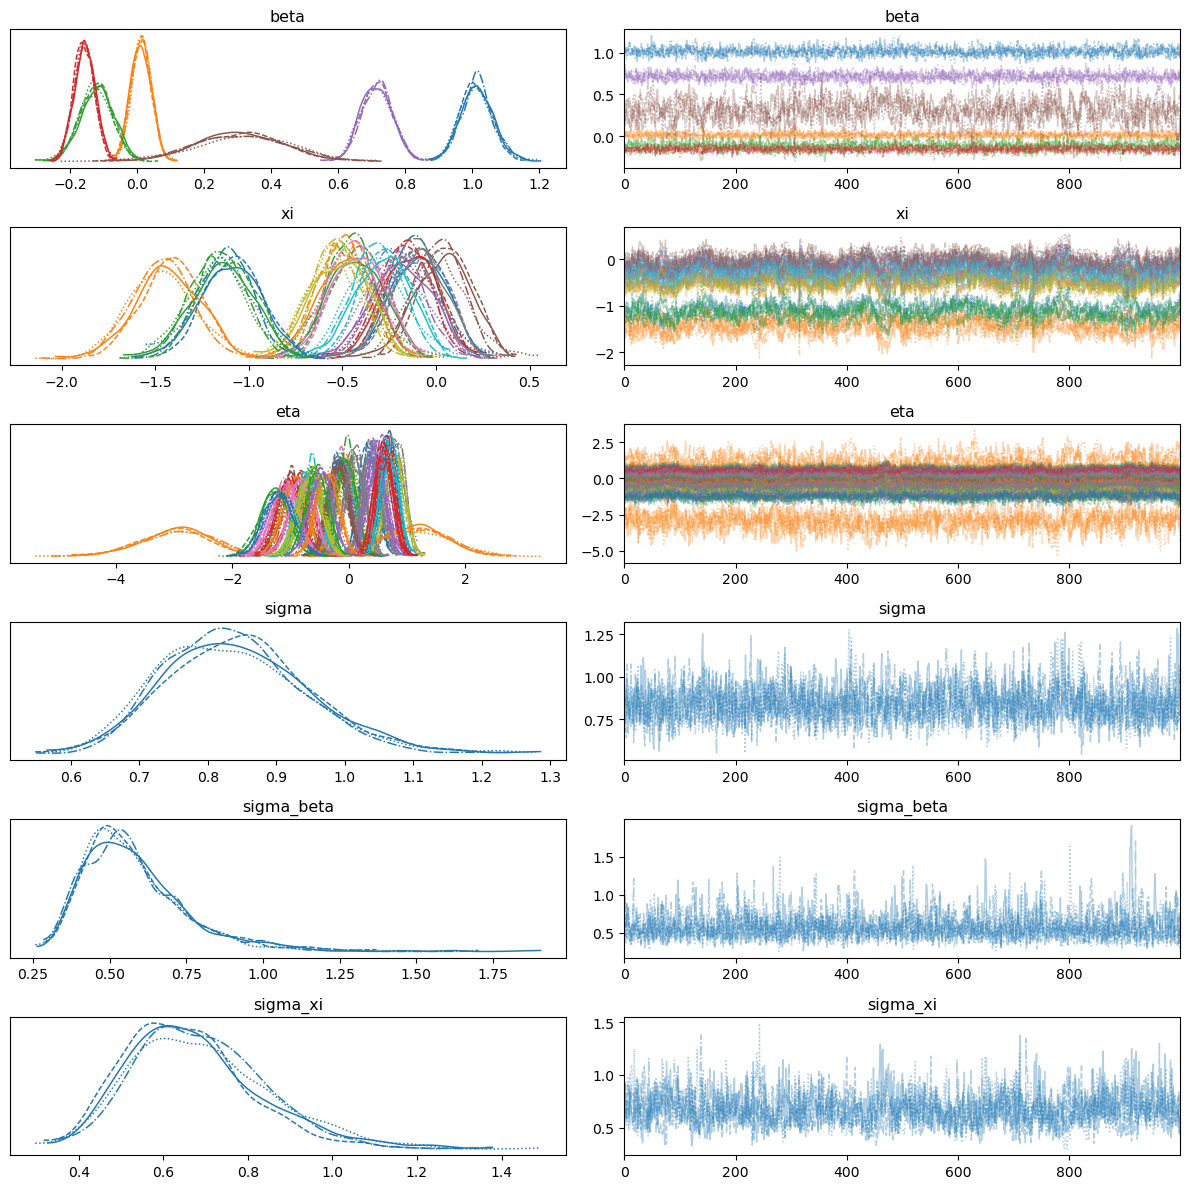

In [17]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_beta', 'sigma_xi'])
plt.tight_layout()
plt.show()

In [18]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\39339\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -3712.28    78.27
p_waic       96.07        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 3808 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3712.88    78.30
p_loo       96.67        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3803   99.9%
 (0.5, 0.7]   (ok)          5    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [19]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [20]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  74  150  187  233  372  384  402  403  441  474  475  529  579  596
  602  656  676  798  851  872  873 1043 1093 1122 1156 1157 1262 1337
 1366 1539 1568 1618 1658 1748 1813 1832 1878 1973 2110 2127 2135 2224
 2240 2338 2371 2389 2440 2449 2518 2532 2563 2569 2672 2705 2750 2769
 2851 2877 2997 3087 3100 3220 3222 3324 3330 3401 3443 3560 3610 3663
 3722 3743]

The total number of outliers is: 72

The MSE is: 2.177389705882353

The MAE is: 0.7179621848739496

The MAD is: 0.0

The percentage of observations inside the CI is: 0.9810924369747899



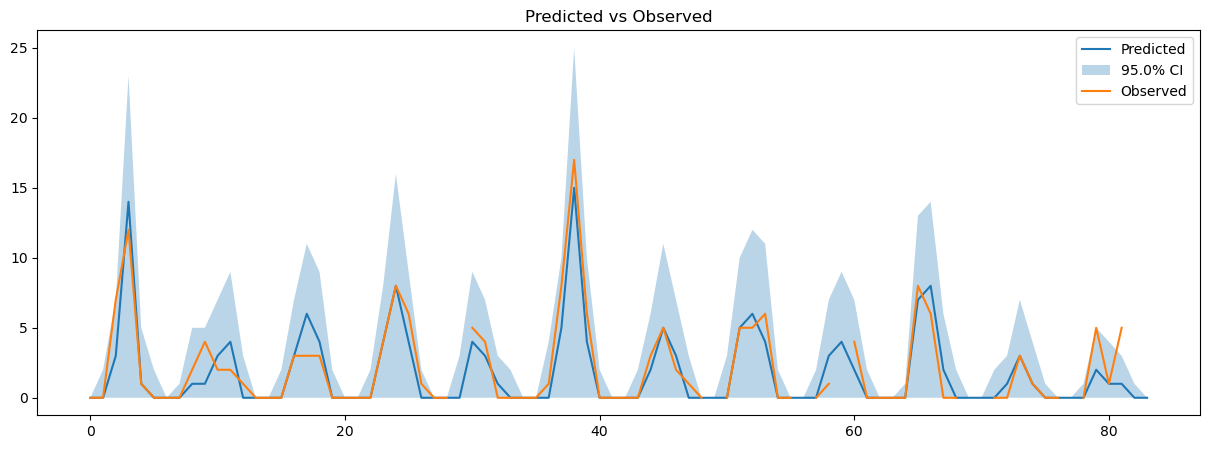

In [21]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

# Final model for 120 dataset

In [28]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = X.drop(['max_consecutive_highwind_days', 'Densità', 'type_rural', 'type_urban'], axis =1)

In [29]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [30]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [31]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [32]:
months_to_repeat = [7]
dummy_july = np.zeros(X.shape[0])
idx_july = np.where(Y['Month'].isin(months_to_repeat))[0]
dummy_july[idx_july] = 1
dummy_july_obs = pd.Series(dummy_july[idx_obs])
dummy_july_miss = pd.Series(dummy_july[idx_miss])


In [33]:
model_120 = FetchModel("space_dummy_rej").compile()

22:48:56 - cmdstanpy - INFO - compiling stan file C:\Users\39339\OneDrive\Desktop\ISEMES~1\BAYESI~2\main\Modello\stan\space_dummy_rej.stan to exe file C:\Users\39339\OneDrive\Desktop\I semestre\Bayesian_Project\main\Modello\stan\space_dummy_rej.exe
22:50:36 - cmdstanpy - INFO - compiled model executable: C:\Users\39339\OneDrive\Desktop\I semestre\Bayesian_Project\main\Modello\stan\space_dummy_rej.exe


In [41]:
data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss,
    "X": X_obs,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_july_obs,
    "dummy_miss": dummy_july_miss
}

fit_120 = model_120.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_120 = az.from_cmdstanpy(fit_120)

23:01:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:15:31 - cmdstanpy - INFO - CmdStan done processing.
23:15:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_dummy_rej.stan', line 58, column 2 to column 63)
Exception: cholesky_dec

In [42]:
post_pred = PostPred(posterior_120, Y['Count_120'])
Y_data = post_pred.Y

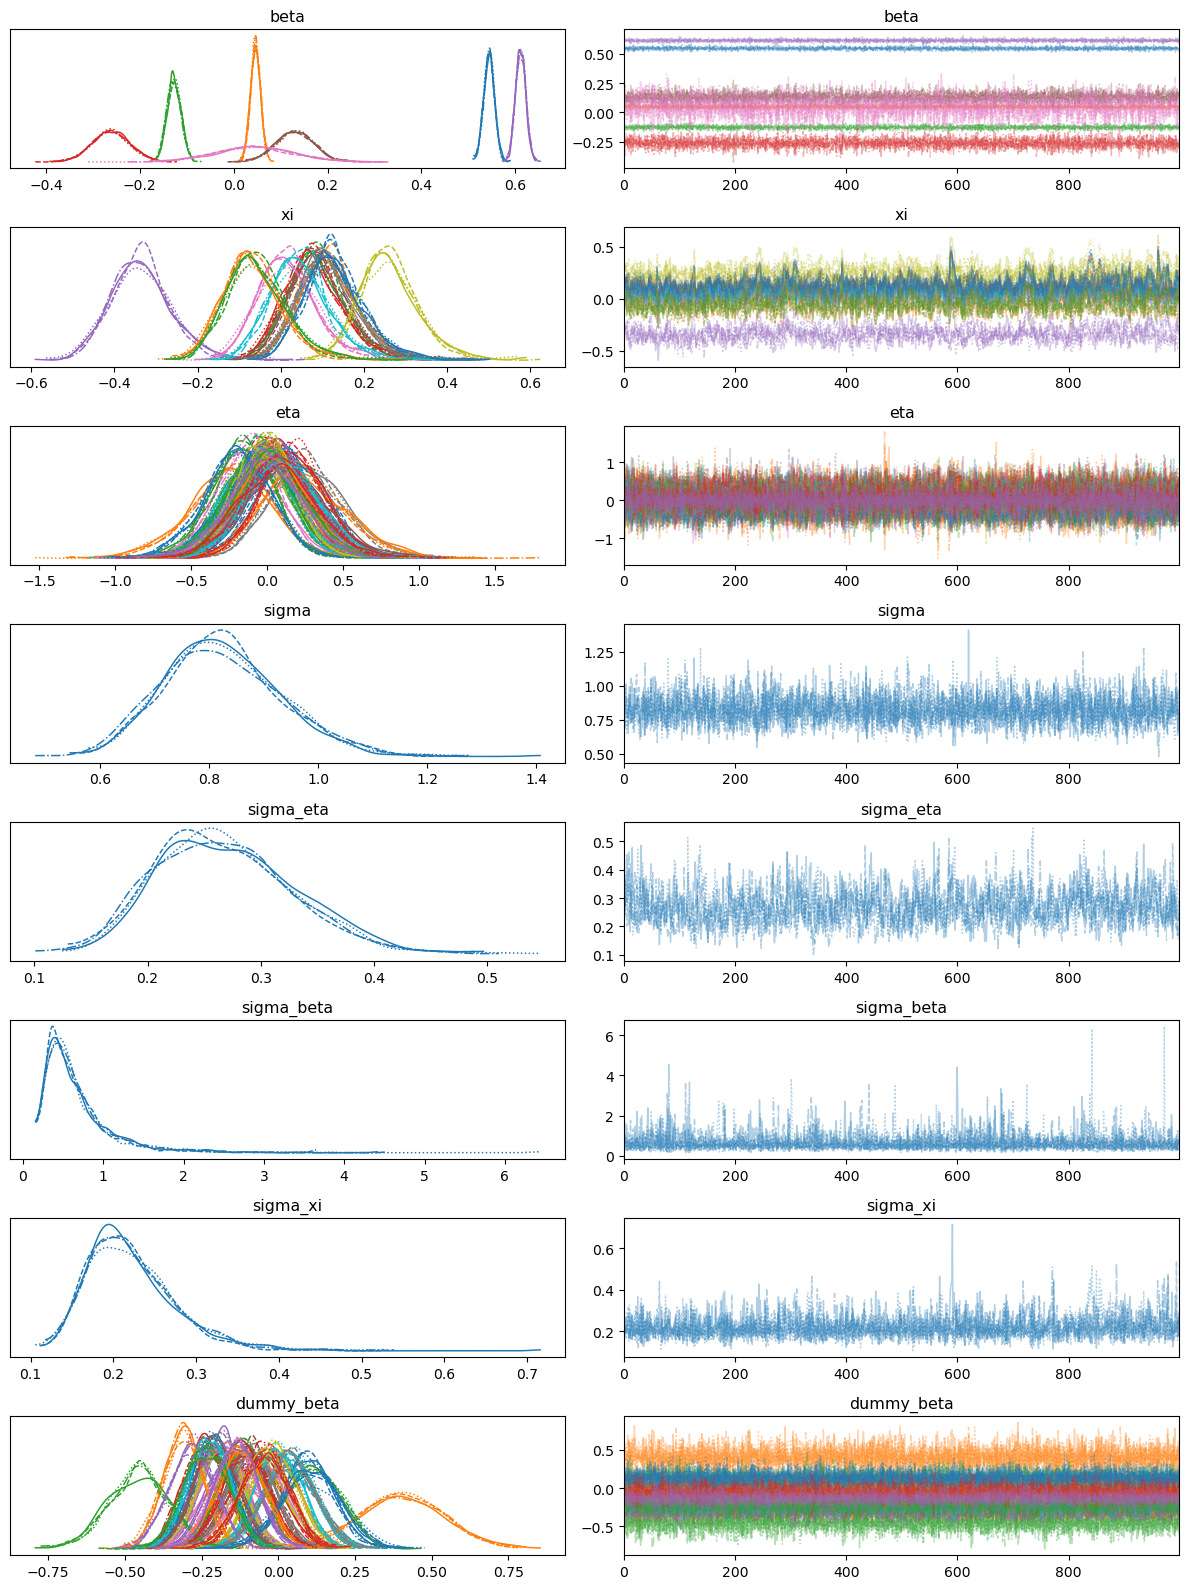

In [43]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'eta', 'sigma', 'sigma_eta', 'sigma_beta', 'sigma_xi', 'dummy_beta'])
plt.tight_layout()
plt.show()

In [44]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

C:\Users\39339\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10061.22    86.82
p_waic      156.48        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10061.99    86.84
p_loo      157.26        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3838   99.9%
 (0.5, 0.7]   (ok)          2    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [45]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [46]:
y_obs, residuals, mse, mae, mad, outliers, percentage_inside = metrics.values()
print(f'Outliers:\n{outliers}\n')
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')

Outliers:
[  21   34   83  145  154  165  173  227  234  308  309  350  351  362
  363  391  394  396  404  410  413  414  420  422  429  430  433  472
  477  478  479  481  482  486  488  493  512  513  519  581  582  585
  588  599  609  618  643  648  650  662  665  669  680  682  685  689
  690  695  701  718  753  757  769  770  771  774  775  781  787  799
  802  807  824  835  842  863  864  869  874  876  877  884  898  901
  917  918  919  920  921  931  950  955  962  984 1016 1019 1021 1022
 1026 1042 1043 1053 1073 1105 1118 1146 1158 1165 1168 1179 1185 1195
 1222 1283 1329 1331 1341 1371 1384 1385 1407 1408 1449 1527 1535 1540
 1552 1553 1559 1563 1611 1631 1667 1765 1774 1786 1824 1859 1867 1869
 1874 1880 1889 1897 1903 1912 1923 1953 1955 1960 1978 1983 1989 2026
 2029 2050 2075 2076 2089 2110 2115 2119 2127 2134 2137 2140 2144 2180
 2198 2214 2221 2227 2228 2234 2238 2241 2251 2274 2291 2301 2315 2327
 2332 2363 2375 2382 2398 2399 2406 2430 2458 2460 2462 2464 2465 2

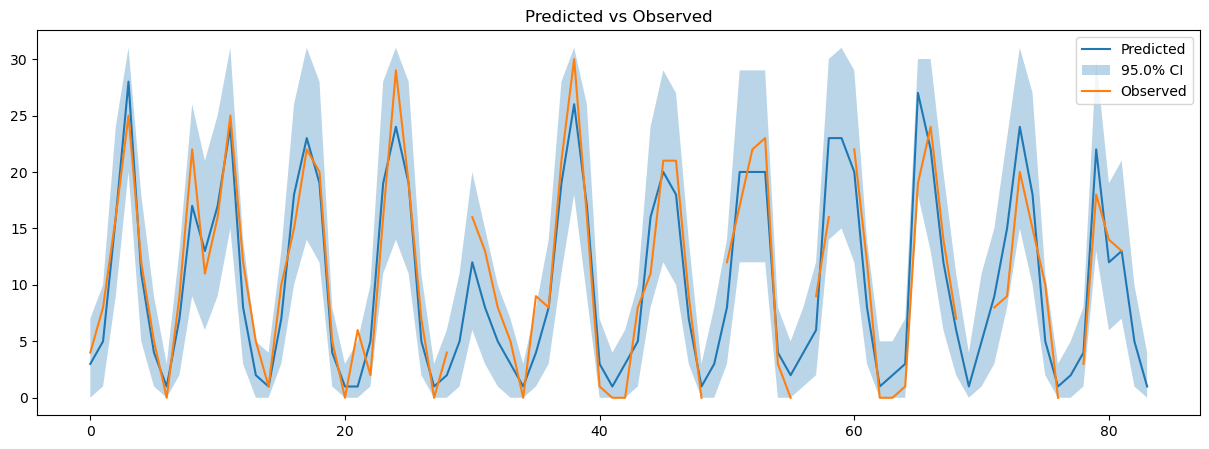

In [48]:
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [49]:
import pickle
with open("model_120.pkl", "wb") as f:
    pickle.dump({'model' : model_120, 'fit' : fit_120}, f, protocol=-1)
with open("model_180.pkl", "wb") as f:
    pickle.dump({'model' : model_180, 'fit' : fit_180}, f, protocol=-1)    